In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [2]:
def is_inside_cube(point, cube_size):
    """
    Defines the imaged object (a cube)

    Returns:
      - If the point is inside the cube: True
      - If the point is outside the cube: False
    """
    half = cube_size / 2
    return all(-half <= coord <= half for coord in point)

In [3]:
def generate_rays(radius, height, n_theta, n_z):
    """
    Generates 3D rays on a cylinder around the origin

    Returns:
      - The origins and directions of the rays
    """

    thetas = np.linspace(0, 2*np.pi, n_theta, endpoint=False)   # n_theta angles around the cube
    zs = np.linspace(-height/2, height/2, n_z)                  # n_z rows of rays from -height/2 to height/2

    origins, directions = [], []
    for z in zs:
        for theta in thetas:
            x = radius * np.cos(theta)
            y = radius * np.sin(theta)
            origins.append([x, y, z])
            directions.append([-x, -y, 0.0]) # direction: inward to axis, no z component
    return np.array(origins), np.array(directions)


In [4]:
def cast_ray(origin, direction, steps, step_size, cube_size):
    """
    Marches along a ray and returns intersection info.

    Returns:
      - If the ray does NOT hit: (1, (), ())
      - If it hits: (0, (x_entry, y_entry, z_entry), (x_exit, y_exit, z_exit))
    """
    pos = np.array(origin, dtype=float)
    dir_norm = direction / np.linalg.norm(direction)

    inside = False
    entry_point = None
    exit_point = None

    for _ in range(steps):
        pos += dir_norm * step_size
        if is_inside_cube(pos, cube_size=cube_size):
            if not inside:
                # first entry point
                inside = True
                entry_point = pos.copy()
        elif inside:
            # we've exited the cube
            exit_point = pos.copy()
            return 0, tuple(entry_point), tuple(exit_point)

    # never entered
    return 1, (), ()


In [5]:
import numpy as np

def collect_data(radius, height, n_theta, n_z, steps, step_size, cube_size, mu=0.02, I_s=1.0):
    """
    Collects projection data for rays around a cube.

    Returns array of shape (n_z, n_theta, 4):
        [0] = hit flag (1 if hit, 0 if not)
        [1] = path length L through cube (0 if no hit)
        [2] = source intensity I_s
        [3] = final intensity I_f (Beer-Lambert law)
    """
    origins, directions = generate_rays(radius, height, n_theta, n_z)
    data = np.zeros((n_z, n_theta, 4), dtype=float)

    for i, (o, d) in enumerate(zip(origins, directions)):
        status, p_in, p_out = cast_ray(o, d, steps, step_size, cube_size)
        z_idx = i // n_theta
        th_idx = i % n_theta

        if status == 0:  # hit the cube
            L = np.linalg.norm(np.array(p_out) - np.array(p_in))
            I_f = I_s * np.exp(-mu * L)
            data[z_idx, th_idx] = [1, L, I_s, I_f]
        else:  # transmitted (no hit)
            data[z_idx, th_idx] = [0, 0.0, I_s, I_s]  # no attenuation

    return data


In [6]:
# imaged object
cube_size = 50

# ray origin and direction
radius = 70
height = 100
n_theta = 32
n_z = 16

# ray marching parameters
steps = 500
step_size = 0.5

# beer-lambert parameters
mu = 0.01
I_s = 1.0

In [7]:
origins, directions = generate_rays(radius, height, n_theta, n_z)

data = collect_data(
    radius=radius,
    height=height,
    n_theta=n_theta, 
    n_z=n_z,
    steps=steps, 
    step_size=step_size,
    cube_size=cube_size, 
    mu=mu,
    I_s=I_s
)

print('Done!')

Done!


In [27]:
# isolate different quantities
hit_mask = data[:, :, 0]
lengths  = data[:, :, 1]
I_s_map  = data[:, :, 2]
I_f_map  = data[:, :, 3]

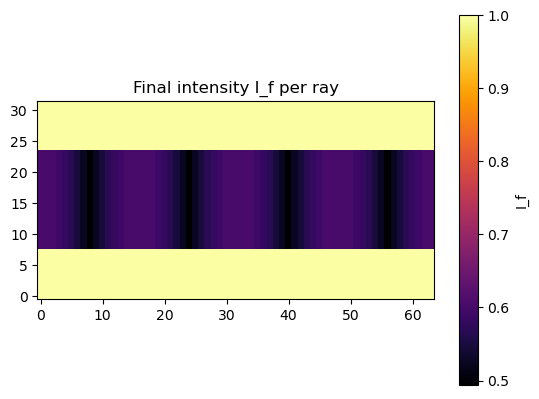

In [42]:
# visualize the intensity attenuation
import matplotlib.pyplot as plt
plt.imshow(I_f_map, cmap='inferno', origin='lower')
plt.title('Final intensity I_f per ray')
plt.colorbar(label='I_f')
plt.show()

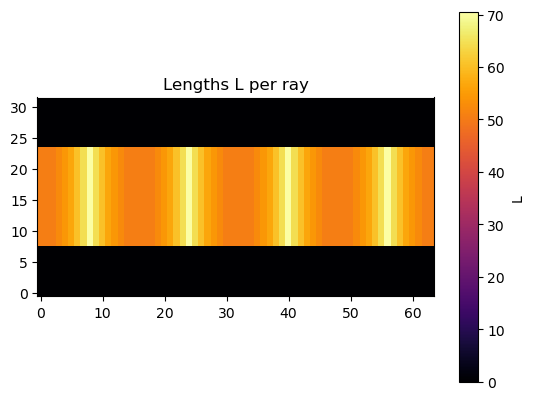

In [43]:
# visualize the length
import matplotlib.pyplot as plt
plt.imshow(lengths, cmap='inferno', origin='lower')
plt.title('Lengths L per ray')
plt.colorbar(label='L')
plt.show()

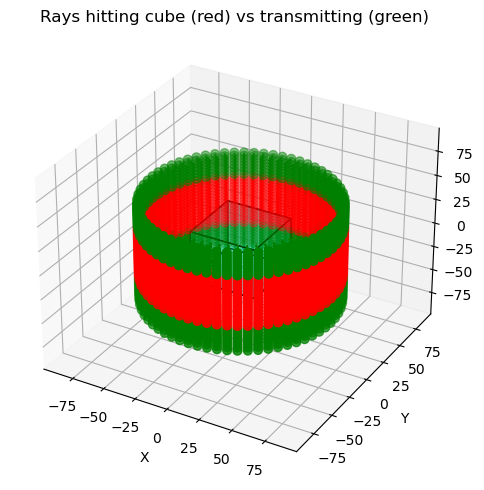

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

def plot_rays_with_cube(origins, directions, data, arrow_length=10.0, cube_size=1.0):
    """
    Visualize rays and a cube.
    
    Parameters:
      origins, directions : arrays of shape (N, 3)
      data : (n_z, n_theta, 4) array OR (n_z, n_theta) hit_mask
             - if 3D: uses data[..., 0] as hit_mask
             - if 2D: uses it directly as hit_mask
      arrow_length : visual ray length
      cube_size : physical cube edge length (for scaling)
    """
    # --- get hit mask
    if data.ndim == 3:
        hit_mask = data[..., 0]
    elif data.ndim == 2:
        hit_mask = data
    else:
        raise ValueError("data must be (n_z, n_theta) or (n_z, n_theta, 4)")

    hit_mask_flat = hit_mask.flatten()

    # --- set up figure
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    # --- draw cube
    half = cube_size / 2.0
    vertices = np.array([[-half, -half, -half],
                         [ half, -half, -half],
                         [ half,  half, -half],
                         [-half,  half, -half],
                         [-half, -half,  half],
                         [ half, -half,  half],
                         [ half,  half,  half],
                         [-half,  half,  half]])
    
    faces = [[vertices[j] for j in [0,1,2,3]],
             [vertices[j] for j in [4,5,6,7]],
             [vertices[j] for j in [0,1,5,4]],
             [vertices[j] for j in [2,3,7,6]],
             [vertices[j] for j in [1,2,6,5]],
             [vertices[j] for j in [4,7,3,0]]]
    
    cube = Poly3DCollection(faces, facecolors='cyan', edgecolors='k', alpha=0.3)
    ax.add_collection3d(cube)

    # --- determine colors
    # hit = red (blocked), no hit = green (transmitted)
    colors = np.where(hit_mask_flat == 1, 'red', 'green')

    # --- plot rays
    for o, d, c in zip(origins, directions, colors):
        ax.quiver(o[0], o[1], o[2], d[0], d[1], d[2],
                  length=arrow_length, normalize=True, color=c, alpha=0.8)

    # --- plot origins (matching colors)
    ax.scatter(origins[:, 0], origins[:, 1], origins[:, 2], c=colors, s=40)

    # --- axes setup
    max_range = np.max(np.linalg.norm(origins, axis=1)) * 1.1
    for axis in 'xyz':
        getattr(ax, f'set_{axis}lim')([-max_range, max_range])

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Rays hitting cube (red) vs transmitting (green)")
    plt.tight_layout()
    plt.show()

plot_rays_with_cube(origins, directions, data, cube_size=cube_size)

Naive reconstruction that leverages the length L(i) for each ray i to reconstruct the 3D volume. Each ray deposits +1 along a chord of length L centered near origin.

In [45]:
import numpy as np

def naive_reconstruct(origins, directions, lengths, grid_size=64, voxel_size=1.0):
    """
    Very naive 3D reconstruction by ray backprojection.
    Each ray deposits +1 along a chord of length L centered near origin.
    """
    volume = np.zeros((grid_size, grid_size, grid_size), dtype=float)

    # define grid coordinate system centered at origin
    half_extent = (grid_size * voxel_size) / 2.0

    def world_to_index(pos):
        return ((pos + half_extent) / voxel_size).astype(int)

    for o, d, L in zip(origins, directions, lengths.flatten()):
        if L <= 0:
            continue  # skip transmitted rays

        d_unit = d / np.linalg.norm(d)
        # center of chord = closest approach of ray to origin
        t_star = -np.dot(o, d_unit)
        p_center = o + t_star * d_unit

        # sample along chord of length L
        n_steps = int(L / (voxel_size / 2))  # oversample
        ts = np.linspace(-L/2, L/2, n_steps)
        for t in ts:
            p = p_center + t * d_unit
            idx = world_to_index(p)
            if np.all((0 <= idx) & (idx < grid_size)):
                volume[idx[2], idx[1], idx[0]] += 1.0  # accumulate votes

    # normalize
    if volume.max() > 0:
        volume /= volume.max()

    return volume

vol = naive_reconstruct(origins, directions, data[..., 1], grid_size=64)

vol.shape

(64, 64, 64)

In [46]:
np.save(f'./out/vol{n_z}_{n_theta}.npy', vol)

Now we use the DDA method.
- we find b_i = log(I_s/I_f), the measured attenuation for each ray
- we then define the voxel grid
- each row of A corresponds to one ray; each column corresponds to one voxel
- A_{ik} = path length of ray i inside voxel k
- we compute this with a ray-voxel traversal algorithm (DDA - Digital Differential Analyzer)
- then we sove the linear system A mu = b (using least-squares)
- A: (#rays x #voxels)
- b: (#rays,)
- mu: (#voxels,)
- then we reshape to 3D and compare with ground truth

In [ ]:
# todo

Here we reconstruct the volume starting with an empty volume and filling voxels where rays are blocked by the object. This is the initial approach that knows the geometry of the object (it calls is_inside_cube() function).

In [ ]:
# here we know the geometry of the object (a 1x1x1 cube)
# so it's easy to asses whether a point is inside or outside the cube

import numpy as np

def is_inside_cube(point, cube_size=1.0):
    half = cube_size / 2
    return all(-half <= coord <= half for coord in point)

def reconstruct_fill_from_blocked(origins, directions, ray_results,
                                  grid_size=100, extent=1.5,
                                  cube_size=1.0, max_dist=3.0, step=0.03):
    """
    Reconstruct a volume starting empty and filling voxels where rays
    are blocked by the object (based on transmission results).
    """
    volume = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)

    def world_to_grid(point):
        idx = ((point + extent) / (2 * extent) * (grid_size - 1)).astype(int)
        return np.clip(idx, 0, grid_size - 1)

    # normalize directions
    directions = directions / np.linalg.norm(directions, axis=1, keepdims=True)

    for o, d, r in zip(origins, directions, ray_results):
        if r == 1:  # transmitted → nothing to fill
            continue
        # blocked ray: walk along its path
        n_steps = int(max_dist / step)
        for i in range(n_steps):
            p = o + d * (i * step)
            if is_inside_cube(p, cube_size):   # if inside true object
                x, y, z = world_to_grid(p)
                volume[x, y, z] = 1            # fill voxel
    return volume


In [14]:
print(origins.shape)
print(directions.shape)
print(ray_results.flatten().shape)

(320, 3)
(320, 3)
(320,)


In [15]:
# reconstruct (fill-based)
volume = reconstruct_fill_from_blocked(origins, directions, ray_results.flatten(),
                                       grid_size=64, extent=1.5,
                                       cube_size=1.0)

In [ ]:
np.save("out/filled_3.npy", volume)

In [15]:
np.unique(volume, return_counts=True)

(array([0., 1.], dtype=float32), array([511990,     10], dtype=int64))